# Synthea/CodeX Data EDA

___
Names: 
>Ali Raza Zaidi & Laiba Zaman

Dates: 
>January 13-17, 2022

Jira Ticket:
>DIG-759

Description:
>EDA of Synthea Data and Selection of Inputs and Outputs to Classifier

### Purpose
We will carry out an Exploratory Data Analysis (EDA) of the [Synthea Data](https://confluence.hl7.org/display/COD/mCODE+Test+Data) ingested into a local katsu environment and accessed through a local GraphQL API Service, as explained through the documentation of the [Federated Learning](https://github.com/CanDIG/federated-learning) and [GraphQL-interface](https://github.com/CanDIG/GraphQL-interface) projects.

The data processing and EDA work done here has been inspired by the work of [Rishabh Sambare](https://github.com/CanDIG/federated-learning/blob/main/examples/synthea-breast-cancer/EDA.ipynb) with his EDA on the Synthea Data.

We will access the data through the local GraphQL API, hosted locally on the 7999 port. The data processing performed in this EDA will come in handy when training our classifier, which will be done in another Jupyter Notebook.

**Import Statements**: We will need to import several libraries to ensure proper functionality within this EDA, as done below

In [1]:
from datetime import datetime # Used for Determining Age at Diagnosis
from typing import List, Dict, Optional, Any # Used to define type hints for functions in the EDA
import requests # Used to access the API for the data
import pandas as pd # Used to cleanup and organize the data
import re # Used to scour the collected data for the stage/category
import seaborn as sns # Used for data visualization
import matplotlib.pyplot as plt # used for data visualization

**Here we will initialize the dataset url to prepare our query for use**

In [2]:
host = 'http://localhost' 
dataset_graphql_url = f'{host}:7999/graphql'

We will not be accessing the following pieces of information from the data due to various reasons. A sample of the dropped data are below. Note some possible MCode fields (Eg. karyotypic sex) are not included here since the Synthea Data did not include them at all

Dropped Data:
- All id / alternate id's: 
    Useless for our purposes
- All 'created' and 'updated' data fields: 
    Useless for our purposes
- 'table' alphanumeric code data: 
    Useless for our purposes
- cancer_condition alphanumeric code data: 
    Useless for our purposes
- condition_type: 
    Useless for our purposes since all were primary
- verfication_status: 
    Useless for our purposes since all were confirmed
- clinical_status: 
    Useless for our purposes since all breast cance cases were active
- cancer_procedure code labels: 
    As Rishabh noted in his EDA Jira Ticket, the data was quite sparse to analyze by 
    specific procedure type so instead we simply analyzed by # of procedures(surgical or radiation)
- cancer_procedures extra properties: 
    Useless for our purposes since it simply had time of operation
- cancer_procedure reason reference alphanumeric code: 
    Useless for our purposes
- genomicsReport: 
    null data
- tnmType: 
    all of the types were clinical TNM's so useless for our purpose
- metastasesCategory:
    The data seemed to indicate the wrong group types (N0, N1, N2, etc.) instead of the required M0 & M1 per the [NCBI](https://www.ncbi.nlm.nih.gov/books/NBK553187/#:~:text=T%20%2D%20Tumor.&text=For%20example%2C%20T1%20indicates%20invasion,an%20invasion%20into%20the%20subserosa.) so these categories were dropped

**Here we will generate the GraphQL Query with all of the data we need to collect**

In [3]:
query = '''
query{
  katsuDataModels
  {
    mcodeDataModels
    {
      mcodePackets{
        subject {
          dateOfBirth
          sex
        }
        cancerCondition {
          dateOfDiagnosis
          tnmStaging{
            stageGroup {
              dataValue {
                label
              }
            }
            primaryTumorCategory{
              dataValue{
                label
              }
            }
            regionalNodesCategory{
              dataValue{
                label
              }
            }
          }
          code{
            label
          }
        }
        cancerRelatedProcedures {
          procedureType
        }
        cancerDiseaseStatus {
          label
        }
        medicationStatement {
          medicationCode {
            label
          }
        }
      }
    }
  }
}
'''

**Here we will execute the query and check to see if it went through (A 200 Status Code indicates success)**

In [4]:
data_json = requests.post(dataset_graphql_url, json={'query': query})
data_json.status_code

200

**Here we will define a dictionary from the collected JSON Data that houses the data for each of the patients**

In [5]:
patient_info_json = data_json.json().get('data').get('katsuDataModels').get('mcodeDataModels').get('mcodePackets')

**Here we define several placeholder values that we will use in the parsing process so that we don't have any errors**

In [6]:
default_label = {'label': None}
default_group = {'dataValue': default_label}
default_staging = [{'stageGroup': default_group, 'primaryTumorCategory': default_group, 
                    'regionalNodesCategory': default_group}]
default_cancer_condition = [{'tnmStaging': default_staging, "dateOfDiagnosis": None, 'code': default_label}]
default_subject = {"date_of_birth": None, "sex": None}
default_procedures = []
default_meds = []

In [7]:
patient_info_json[1] # Example Data

{'subject': {'dateOfBirth': '1970-03-21', 'sex': 'FEMALE'},
 'cancerCondition': [{'dateOfDiagnosis': '2020-03-08T22:34:14Z',
   'tnmStaging': [{'stageGroup': {'dataValue': {'label': 'Stage 2 (qualifier value)'}},
     'primaryTumorCategory': {'dataValue': {'label': 'T3 category (finding)'}},
     'regionalNodesCategory': {'dataValue': {'label': 'N0 category (finding)'}}},
    {'stageGroup': {'dataValue': {'label': 'Stage 2B (qualifier value)'}},
     'primaryTumorCategory': {'dataValue': {'label': 'T3 category (finding)'}},
     'regionalNodesCategory': {'dataValue': {'label': 'N0 category (finding)'}}}],
   'code': {'label': 'Malignant neoplasm of breast (disorder)'}}],
 'cancerRelatedProcedures': [{'procedureType': 'surgical'}],
 'cancerDiseaseStatus': None,
 'medicationStatement': [{'medicationCode': {'label': 'DOXOrubicin hydrochloride 20 MG per 10 ML Injection'}}]}

**Here we define several functions and values that will be used in the parsing process**

In [8]:
'''
    get_uniq_procedures(): returns a List of strings containing the unique procedure types within the collected data
'''
def get_uniq_procedures() -> List[str]:
    procedures = []
    for patient in patient_info_json:
        procedures.extend([procedure.get('procedureType') for procedure in patient.get('cancerRelatedProcedures', default_procedures)])
        
    return list(set(procedures))

'''
    get_uniq_meds(): returns a List of strings containing the unique medication types within the collected data
'''
def get_uniq_meds() -> List[str]:
    meds = []
    for patient in patient_info_json:
        meds.extend([med.get('medicationCode').get('label') for med in patient.get('medicationStatement', default_meds)])
        
    return list(set(meds))

'''
    meds_wrapper(meds): Passed in an Optional List of Dictionaries, the function returns a Dictionary with string keys and int
        values that display the unique medications as keys and display the number of times the specified patient takes the given
        medication as its value
'''
def meds_wrapper(meds: Optional[List[Dict[str, Any]]]) -> Dict[str, int]:
    meds_dict = dict.fromkeys(uniq_meds, 0)
    for med in meds:
        meds_dict[med.get('medicationCode').get('label')] += 1
    
    return meds_dict

'''
    procedure_Wrapper(procedures): Passed in an Optional List of Dictionaries, the function returns a Dictionary of string keys 
        and int values where the keys represent the different procedure types and the values represent the number of times that
        procedure was performed on the specified patient
'''
def procedure_wrapper(procedures: Optional[List[Dict[str, Any]]]) -> Dict[str, int]:
    procedures_dict = dict.fromkeys(uniq_procedures, 0)
    for procedure in procedures:
        procedures_dict[procedure.get('procedureType')] += 1
    
    return procedures_dict

''' sex_wrapper(sex): Passed in an Optional string, this function returns an Optional integer with 1 for a female sex specified 
        and 0 otherwise
'''
def sex_wrapper(sex: Optional[str]) -> Optional[int]: 
    if sex is not None: 
        if sex == 'FEMALE': return 1
        return 0
    return None

'''
    age_wrapper(age, diag): Passed in two Optional strings, age and diag related to the date of birth and date of diagnosis of
        the patient respectively, and returns an optional integer specifying the number of days between the date of diagnosis
        and the date of birth of the patient
'''
def age_wrapper(age: Optional[str], diag: Optional[str])-> Optional[int]:
    if age is not None and diag is not None: return get_age(age, diag)
    return None

''' 
    get_age(age, diag): Passed in two strings, age and diag corresponding do the date of birth and date of diagnosis of the
        patient, respectively, and returns an integer specifying the number of days between the two events
'''
def get_age(age: str, diag: str) -> int:
    date_of_birth = datetime.strptime(age, "%Y-%m-%d")
    date_of_diagnosis = datetime.strptime(diag, "%Y-%m-%dT%H:%M:%SZ")
    diff = date_of_diagnosis - date_of_birth
    return diff.days

'''
    status_wrapper(cancer_status): Passed in an optional string, this function returns an optional integer where 1 represents
        an improvement in patient health and 0 represents a decline in patient health
'''
def status_wrapper(cancer_status: Optional[str]) -> Optional[int]:
    if cancer_status is not None: return get_status(cancer_status.get('label'))
    return None

'''
    get_status(cancer_status): Passed in a string, this function returns an integer value representing either an improvement or
        decline in the patient's health
'''
def get_status(cancer_status: str) -> int:
    if cancer_status == "Patient's condition improved": return 1
    return 0

'''
    stage_wrapper(cancer_stagings): Passed in an Optional List of Dictionaries, this function returns a Dictionary with string
        keys and integer values which represent the stage of the cancer/tumour/nodes/metastases
'''
def stage_wrapper(cancer_stagings: Optional[List[Dict[str, Any]]]) -> Dict[str, int]:
    if cancer_stagings is not None: 
        stage = get_stage(
            cancer_stagings[0].get('stageGroup', default_group).get('dataValue', default_label).get('label', None))
        primary = get_primary(
            cancer_stagings[0].get('primaryTumorCategory', default_group).get('dataValue', default_label).get('label', None))
        nodes = get_nodes(
            cancer_stagings[0].get('regionalNodesCategory', default_group).get('dataValue', default_label).get('label', None))
        return {'stage': stage, 'primary': primary, 'nodes': nodes}
    return {'stage': None, 'primary': None, 'nodes': None}

'''
    get_stage(given_stage): Passed in a str, this function returns the stage of cancer the patient is in
'''
def get_stage(given_stage: str) -> Optional[int]:
    if re.search(r'[sS]tage 1', given_stage): return 1
    if re.search(r'[sS]tage 2', given_stage): return 2
    if re.search(r'[sS]tage 3', given_stage): return 3
    if re.search(r'[sS]tage 4', given_stage): return 4
    return None

'''
    get_primary(given_stage): Passed in a str, this function returns the stage of primary tumours the patient has
'''
def get_primary(given_stage: str) -> Optional[int]:
    if 'T0' in given_stage: return 0
    if 'T1' in given_stage: return 1
    if 'T2' in given_stage: return 2
    if 'T3' in given_stage: return 3
    if 'T4' in given_stage: return 4
    return None

'''
    get_nodes(given_stage): Passed in a str, this function returns the stage of the regional nodes
'''
def get_nodes(given_stage: str) -> Optional[int]:
    if 'N0' in given_stage: return 0
    if 'N1' in given_stage: return 1
    if 'N2' in given_stage: return 2
    if 'N3' in given_stage: return 3
    return None

'''
    Defining the unique medications and procedure types
'''
uniq_procedures = get_uniq_procedures()
uniq_meds = get_uniq_meds()

**Here we take the data from the json and parse it into the formats that we want our input data to have**

In [9]:
patient_info_list = []
for patient in patient_info_json:
    patient_info_dict = {}
    cancer_status = status_wrapper(patient.get('cancerDiseaseStatus', default_label))
    date_of_birth = patient.get('subject', default_subject).get('dateOfBirth')
    date_of_diagnosis = patient.get('cancerCondition', default_cancer_condition)[0].get('dateOfDiagnosis')
    diagnosis_age = age_wrapper(date_of_birth, date_of_diagnosis)
    sex = sex_wrapper(patient.get('subject', default_subject).get('sex'))
    stages = stage_wrapper(patient.get('cancerCondition', default_cancer_condition)[0].get('tnmStaging'))
    cancer_type = patient.get('cancerCondition', default_cancer_condition)[0].get('code', default_label).get('label', None)
    procedures = procedure_wrapper(patient.get('cancerRelatedProcedures', default_procedures))
    
    for procedure in uniq_procedures:
        patient_info_dict[procedure] = procedures[procedure]
    
    meds = meds_wrapper(patient.get('medicationStatement', default_meds))
    number_of_meds = sum([quantity for (medicine, quantity) in meds.items()])
    
    patient_info_dict['cancerStatus'] = cancer_status
    patient_info_dict['diagnosisAge'] = diagnosis_age / 365.25
    patient_info_dict['sex'] = sex
    patient_info_dict['stage'] = stages['stage']
    patient_info_dict['primary'] = stages['primary']
    patient_info_dict['nodes'] = stages['nodes']
    patient_info_dict['numberOfMeds'] = number_of_meds
    patient_info_dict['cancerType'] = cancer_type
    patient_info_list.append(patient_info_dict)

**Here we create our DataFrame and remove rows with null values, male cases or non-breast cancer cases**

In [10]:
pd.set_option('display.max_columns', None)

df = pd.DataFrame(patient_info_list)
df = df.dropna(subset=['numberOfMeds', 'nodes', 'primary', 'stage', 'sex', 'diagnosisAge', 'cancerStatus'])
df = df.loc[df['sex'] != 0]
df = df.loc[df['cancerType'] == 'Malignant neoplasm of breast (disorder)']
df = df.drop(columns=['cancerType', 'sex'])
df = df.reset_index(drop=True)

**Viewing the DataFrame**

In [11]:
df

,radiation,surgical,cancerStatus,diagnosisAge,stage,primary,nodes,numberOfMeds
0,0,1,1.0,54.962355,1.0,1.0,0.0,10
1,0,2,1.0,59.958932,3.0,2.0,2.0,19
2,34,1,1.0,65.954825,1.0,1.0,0.0,1
3,34,2,1.0,51.964408,2.0,2.0,1.0,16
4,34,2,1.0,67.953457,2.0,2.0,1.0,1
...,...,...,...,...,...,...,...,...
1395,34,1,1.0,38.973306,1.0,1.0,0.0,3
1396,34,1,1.0,67.953457,1.0,1.0,0.0,16
1397,0,1,1.0,64.955510,1.0,1.0,0.0,11
1398,34,1,1.0,49.965777,2.0,2.0,0.0,16


**Here we will create a correlation matrix for each of the fields of the DataFrame to get an idea of which fields are correlated**

In [12]:
corr = df.corr()

**Viewing the Correlation Matrix**

In [13]:
corr

,radiation,surgical,cancerStatus,diagnosisAge,stage,primary,nodes,numberOfMeds
radiation,1.000000,-0.064435,0.046392,0.055335,-0.117201,-0.090404,-0.105332,-0.522895
surgical,-0.064435,1.000000,-0.155533,-0.007651,0.643939,0.409380,0.758097,0.327867
cancerStatus,0.046392,-0.155533,1.000000,0.012378,-0.276155,-0.214418,-0.210710,-0.159637
diagnosisAge,0.055335,-0.007651,0.012378,1.000000,-0.014631,-0.012677,-0.040946,-0.033861
stage,-0.117201,0.643939,-0.276155,-0.014631,1.000000,0.778215,0.798279,0.477475
primary,-0.090404,0.409380,-0.214418,-0.012677,0.778215,1.000000,0.427094,0.326141
nodes,-0.105332,0.758097,-0.210710,-0.040946,0.798279,0.427094,1.000000,0.466521
numberOfMeds,-0.522895,0.327867,-0.159637,-0.033861,0.477475,0.326141,0.466521,1.000000


**Here we create a heatmap of the correlation matrix**

<AxesSubplot:>

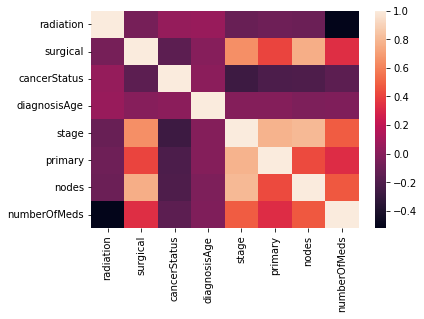

In [14]:
sns.heatmap(corr)

We can see that most of the fields don't seem to be correlated with the others, however, the *stage* category does seem to be slightly different, hence why we will try to use this header as the output for our classifier

___
In the end, we find that a suitable list of inputs for our classifiers can be:
- surgical: Number of surgeries performed on the patient
    - int between \[0 .. \*\]
- radiation: Number of radiation therapy sessions performed on the patient
    - int between \[0 .. \*\]
- cancerStatus: Whether or not the patient's condition improved
    - int between \[0 .. 1\]
- diagnosisAge: At what age the person was diagnosed with cancer
    - float between \[0.0 .. \*\]
- primary: The patient's primary tumour category
    - int between \[0 .. 4\]
- nodes: The patient's regional node category
    - int between \[0 .. 3\]
- numberOfMeds: The number of medications given to the patient
    - int between \[0 .. \*\]

The output we determined to be optimal for our analysis was:
- stage: The clinical cancer stage of the patient
    - int between \[0 .. 4\]

Finally, we now decide on what classifier to use on our data. We took a look at several different classifiers, from Support Vector Classifiers (SVC) to Naive Bayesian Classifiers. We ended up choosing our default classifier to be the Decision Tree Classifier, although we were quite interested in the Random Forest, KNN, Support Vector and Naive-Bayesian classifiers as alternative options. We chose to do this because Decision Trees are [easy to interpret, require minimal processing and are robust](https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575#:~:text=Even%20though%20Decision%20trees%20is,all%20types%20of%20data%20nicely.)

**We now download the collected data into a useable file format for further classification**

In [15]:
df.to_csv(path_or_buf='SyntheaEDA.csv', index=False)